# Detecting Bias on Reddit Using NLP Analysis and Linear Regression

The aim of this notebook is to detect whether bias exists in the news that Reddit users receive while browsing the world news subreddit.

On Reddit, the number of upvotes influences how visible an article becomes. If a post initially receives more upvotes or downvotes due to the topic of the post, then those topics will be more or less likely (respectively) to be seen by the average Reddit user.

Linear regression can be used to discover the existence of bias by determining if certain features, specifically certain terms, can influence the amount of upvotes a post receives on Reddit. 

The final model for the analysis was made using linear regression on following variables:
* Target Variable:
    * Logged upvotes
* Potential Feature Variables:
    * Article word counts (count vectorizer)
    * Article TFIDF
    * Ratio of most commonly used words
    * Linked website
    * Time posted
    * Age of post
    * Title length

These variables will be discussed in detail as they appear in the notebook.

### Section breakdown:
1. Import Libraries
2. Import Data
3. Data Cleaning (Non-text features)
4. Feature Engineering
5. Analyze the "Upvote" Variable
6. Create Dummy Variables 
7. Convert Text Data to Sparse Matrix Using Count Vectorizer
8. Regress
9. Test Model Performance
10. Final Analysis

# 1. Import Libraries

In [1]:
# Data Manipulation 
import pandas as pd
import numpy as np
import datetime

# Data Storage
import pickle

# NLP Analysis
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Linear Regression 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, RidgeCV

# Hide Depreciation Warnings
import warnings
warnings.filterwarnings('ignore')

# 2. Import Data
Data was obtained from web scraping. It was scraped at 1-2 day intervals to obtain more data as Reddit only saves a certain amount locally.

In [2]:
df1 = pd.read_csv('raw_data/post_data_10_4.csv',index_col='Unnamed: 0')
df2 = pd.read_csv('raw_data/post_data_10_6.csv',index_col='Unnamed: 0')
df3 = pd.read_csv('raw_data/post_data_10_7.csv',index_col='Unnamed: 0')
df4 = pd.read_csv('raw_data/post_data_10_8.csv',index_col='Unnamed: 0')
df5 = pd.read_csv('raw_data/post_data_10_9.csv',index_col='Unnamed: 0')
df6 = pd.read_csv('raw_data/post_data_10_10.csv',index_col='Unnamed: 0')

In [3]:
df = pd.concat([df6,df5,df4,df3,df2,df1]) # Combine the dataframes

Due to the manner in which the data was obtained, there are duplicate posts (where the same post exists at different ages). The newer posts should be deleted so that the posts with more upvotes, comments, etc are saved.

In [4]:
df = df.drop_duplicates(subset=['title']).reset_index(drop=True)

In [5]:
df.head()

,upvotes,title,site,time_posted,post_age,comment_no
0,0,The Far Right Isn’t the Only Rising Force in G...,theatlantic.com,2018-10-10 18:49:33,0 days 00:02:20.444008000,0
1,0,Mexico: Mayor accused of spending taxpayers' m...,mexiconewsdaily.com,2018-10-10 18:48:57,0 days 00:02:56.444011000,0
2,0,Chinese spy charged with stealing U.S. militar...,washingtonpost.com,2018-10-10 18:48:22,0 days 00:03:31.444012000,1
3,0,Mexico: 5 Mexico City police arrested for stea...,mexiconewsdaily.com,2018-10-10 18:43:55,0 days 00:07:58.444012000,0
4,0,Mexico: World Justice Project study finds weak...,mexiconewsdaily.com,2018-10-10 18:40:32,0 days 00:11:21.444013000,1


# 3. Data Cleaning (Non-text features)

Cleaning performed:
* Convert the time posted to datetime
* Convert the age of the post to a timedelta
* Delete posts under three hours
    * In this way, posts that haven't had enough time for maximum upvote potential aren't taken into account. Most posts under 3 hours have 0 upvotes.

### Convert to datetime

In [6]:
df['time_posted'] = pd.to_datetime(df['time_posted'])

### Convert post age to timedelta

In [7]:
def to_timedelta(item):
    return pd.Timedelta(item[:-10]) # Removes milliseconds

df['post_age'] = df['post_age'].apply(to_timedelta)

### Delete posts under three hours

In [8]:
three_hours = pd.Timedelta('3 hours')
df = df[df.post_age >= three_hours].reset_index(drop=True)

# 4. Feature Engineering

Feautres created:
* The hour of day that the post was made
    * The time of day could impact the number of upvotes, as the volume of Reddit users changes throughout the day.
* Post title length
    * This feature could affect the number of upvotes as shorter titles could be easier to read. Alternatively, longer titles could contain more interesting information.

### Hour of day that the post was made

In [9]:
def to_hour(item):
    return item.hour

df['hour_posted'] = df['time_posted'].apply(to_hour)

### Post title length

In [10]:
def length(item):
    sentence = item.split(" ")
    return len(sentence)

df['title_length'] = df['title'].apply(length)

In [11]:
df.head()

,upvotes,title,site,time_posted,post_age,comment_no,hour_posted,title_length
0,7,Soaring Rice Prices Are Dulling Duterte’s Lust...,nytimes.com,2018-10-10 15:49:49,03:02:05,2,15,9
1,11,Man who sold stolen identities sentenced to pr...,reuters.com,2018-10-10 15:38:01,03:13:53,2,15,11
2,42,China okays massive re-education camps for Mus...,businessinsider.com,2018-10-10 15:35:19,03:16:35,8,15,13
3,17,Indonesian tourists vandalize Olmec monumental...,theyucatantimes.com,2018-10-10 15:28:44,03:23:10,5,15,8
4,5,UNESCO: Rachel's Tomb and Cave of Patriarchs p...,jpost.com,2018-10-10 15:27:11,03:24:43,7,15,11


# 5. Analyze the "Upvote" Variable

This is the target variable, so analysis of it is key.

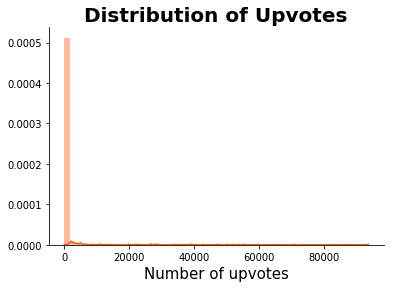

In [12]:
# Plot the distribution 
sns.distplot(df['upvotes'].values, color= '#FF5700');
plt.title('Distribution of Upvotes', fontsize = 20, weight = 'bold')
plt.xlabel('Number of upvotes', fontsize = 15)
sns.despine();

In [13]:
df['upvotes'].describe()

count     2254.000000
mean       887.414818
std       6084.253352
min          0.000000
25%          5.000000
50%         12.000000
75%         39.000000
max      93700.000000
Name: upvotes, dtype: float64

This is a very skewed distribution and needs to be normalized. In terms of regression, this will mean that the model can no longer predict a concrete amount of upvotes. Thankfully, to find bias, we are more interested in upvotes on posts relative to other posts than the actual score on each post, so this doesn't change the problem.

In [14]:
df["upvotes_logged"] = np.log1p(df.upvotes) # Logged upvotes
df['double_log'] = np.log1p(df.upvotes_logged) # Double logged upvotes

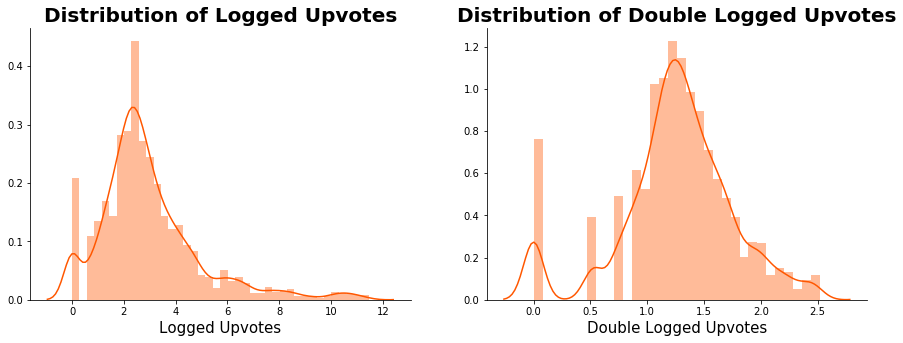

In [15]:
# Plot the distribution of logged upvotes
plt.figure(figsize=[15,5])

plt.subplot(1,2,1)
sns.distplot(df['upvotes_logged'], color= '#FF5700')
plt.title('Distribution of Logged Upvotes', fontsize = 20, weight = 'bold')
plt.xlabel('Logged Upvotes', fontsize = 15)
sns.despine();


plt.subplot(1,2,2)
sns.distplot(df['double_log'], color= '#FF5700')
plt.title('Distribution of Double Logged Upvotes', fontsize = 20, weight = 'bold')
plt.xlabel('Double Logged Upvotes', fontsize = 15)
sns.despine();

In [16]:
df.describe()

,upvotes,post_age,comment_no,hour_posted,title_length,upvotes_logged,double_log
count,2254.000000,2254,2254.000000,2254.000000,2254.000000,2254.000000,2254.000000
mean,887.414818,1 days 22:16:57.894853,70.420586,11.685892,14.936114,2.974696,1.262807
std,6084.253352,0 days 21:05:25.488515,394.964544,5.935801,10.077216,1.973716,0.498840
min,0.000000,0 days 03:02:05,0.000000,0.000000,4.000000,0.000000,0.000000
25%,5.000000,1 days 07:37:58.750000,1.000000,7.000000,9.000000,1.791759,1.026672
50%,12.000000,2 days 01:54:15,4.000000,12.000000,11.000000,2.564949,1.271150
75%,39.000000,2 days 13:51:39,13.000000,16.000000,15.000000,3.688879,1.545194
max,93700.000000,3 days 12:32:14,7730.000000,23.000000,53.000000,11.447864,2.521549


The distributions of both the logged and double logged upvotes are much closer to normal distributions than the original variable's. Because taking the double log creates quite a disproportionate amount of 0s, it makes sense to use the logged upvotes as the target.

In [17]:
# Save data as a pickle file
with open('pickle_files/dataframe.pkl', 'wb') as picklefile:
    pickle.dump(df, picklefile)

# 6. Create Dummy Variables 

Dummy variables created:
* Linked Sites:
    * The original source of the news article posted on Reddit
    * This feature could impact upvotes as some sites may be more credible or favored on Reddit
* Time of Day Posted:
    * The hour of the day that the post was created (saved as numbers, where each number represents an hour in a 24 hour clock)
    * While there's already a "Time of Day Posted" variable, treating it as a dummy variable rather than a continuous one could combat the value of the hour of the day being treated as numerical and averaging out.
* Age of the Post:
    * How long the post had been up before the data was scraped
    * While posts that were too new were already removed, time is definitely a factor in the number of upvotes as the longer a post has been up, the more opportunity it has to receive upvotes

### Dummy variables for each linked site

In [18]:
sites_dummy = pd.get_dummies(df['site']) # Create a seperate dummy variable dataframe
# Drop infrequently used sites to prevent overfitting
sites_dummy.drop([col for col, val in sites_dummy.sum().iteritems() if val < 15], axis=1, inplace=True)

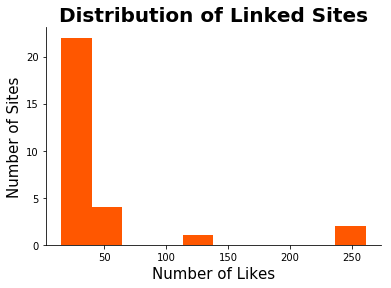

In [19]:
# Plot the distribution
plt.hist(sites_dummy.sum(), color= '#FF5700')
plt.title('Distribution of Linked Sites', fontsize = 20, weight = 'bold')
plt.xlabel('Number of Likes', fontsize = 15)
plt.ylabel('Number of Sites', fontsize = 15)
sns.despine();

In [20]:
sites_dummy.sum().sort_values(ascending=False)

reuters.com            261
theguardian.com        246
bbc.com                130
bbc.co.uk               62
independent.co.uk       49
aljazeera.com           46
dw.com                  45
edition.cnn.com         37
cbc.ca                  34
apnews.com              32
nytimes.com             31
cnbc.com                31
washingtonpost.com      26
timesofisrael.com       24
news.sky.com            24
abc.net.au              24
bloomberg.com           23
thedailybeast.com       23
cnn.com                 21
japantimes.co.jp        20
channelnewsasia.com     19
businessinsider.com     19
abcnews.go.com          19
scmp.com                17
france24.com            16
themoscowtimes.com      16
en.crimerussia.com      15
euractiv.com            15
dailymail.co.uk         15
dtype: int64

The sites listed above are the most frequently linked. Reuters, The Guardian, and BBC are by far the most commonly linked sites.

### Time posted dummy variables

In [21]:
hour_dummy = pd.get_dummies(df['hour_posted'])

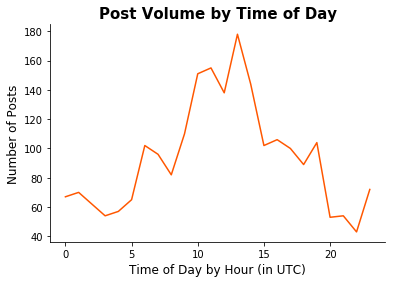

In [22]:
# Plot the posts by time of day
hour_dummy.sum().plot(color= '#FF5700')
plt.title('Post Volume by Time of Day', fontsize = 15, weight = 'bold')
plt.ylabel('Number of Posts', fontsize = 12)
plt.xlabel('Time of Day by Hour (in UTC)', fontsize = 12)
sns.despine();

Most Reddit users seem to post at UTC 13:00, which could be first thing in the morning for a large portion of the users.

### Post age dummy variables

In [23]:
# Make bins in increments of 5 hours with labels
bins = []
labels = []
for item in range(0,90,5):
    string = str(item) + 'hours'
    bins.append(pd.Timedelta(string))
    labels.append(item)
    
labels = labels[1:]

In [24]:
# Categorize each post into a bin
df['post_age_hours'] = pd.cut(df['post_age'], bins=bins, labels=labels)

In [25]:
# Create the dummy variables
age_dummy = pd.get_dummies(df['post_age_hours'])

In [26]:
# Convert time to seconds
def to_secs(item):
    return item.total_seconds()

df['post_age'] = df['post_age'].apply(to_secs)

### Save dataframes as pickle files

In [27]:
with open('pickle_files/sites_dummy.pkl', 'wb') as picklefile:
    pickle.dump(sites_dummy, picklefile)
    
with open('pickle_files/hour_dummy.pkl', 'wb') as picklefile:
    pickle.dump(hour_dummy, picklefile)
    
with open('pickle_files/age_dummy.pkl', 'wb') as picklefile:
    pickle.dump(age_dummy, picklefile)

# 7. Convert Text Data to Sparse Matrix Using Count Vectorizer

We can transform all words used in this dataset into features to use in the regression. Using count vectorized features, the regression runs on the count of the words used for each post. This can show us which words have a strong effect on upvotes. Alternatively, we could use the TFIDF as features (however, through cross validation, counts work better for this problem).

In [28]:
# Convert titles to only lowercase letters (remove all other symbols)
df['title'] = df['title'].str.replace('[^a-z, A-Z]', '')

Initialize the count vectorizer with stop words set to English (this will remove all words that aren't English which might be typos or uncommon) and ngrams set to two (which will take two word combinations into account)

In [29]:
count_vect = CountVectorizer(stop_words = 'english', ngram_range=(1, 2)) # Initialize the count vectorizer
# Creates the sparse matrix containing words as columns and counts for each post in the rows
counts = count_vect.fit_transform(df['title'])
counts.shape

(2254, 24153)

In [30]:
# Create a dataframe with the counts
count_words_df = pd.DataFrame(data=counts.toarray(),columns=count_vect.get_feature_names())

In [31]:
# See most commonly used words
common_words = count_words_df.sum().sort_values()
common_words.tail(10)

trump       70
india       72
said        77
russia      79
russian     86
uk          96
saudi      107
new        128
china      141
says       176
dtype: int64

In [32]:
# Dataframe without seldom used words to avoid overfit
word_series = common_words.loc[common_words >= 10] # Pandas series of all words used more than 10 times
word_list = list(word_series.index.values) # List of those words
select_count = count_words_df[word_list] # New dataframe referencing with columns as word_list words

Now that we have the most commonly used words, we can engineer a new feature: the number of top words used divided by length of the post. This is effectively the ratio of common words used in each title. Regression on this feature would give an indication if using more commonly used words will result in more or less upvotes. (This feature is unusable if modeling on the reduced word dataframe, select_count)

In [33]:
select_count['sum'] = select_count.sum(axis=1) # Creates a column that is a sum of all commonly used words
count_whole_df = pd.concat([df.reset_index(drop=True), select_count.reset_index(drop=True)], axis= 1) # Combined df
count_whole_df["average"] = (count_whole_df["sum"]/count_whole_df["title_length"]) # Create the "average" variable
count_avg = count_whole_df["average"] # Isolate the variable

In [34]:
# Save data as a pickle files
with open('pickle_files/all_word_counts.pkl', 'wb') as picklefile:
    pickle.dump(count_words_df, picklefile)
    
with open('pickle_files/select_word_counts.pkl', 'wb') as picklefile:
    pickle.dump(select_count, picklefile)

# 8. Regress

In [35]:
# After cross validation, the following combination of features results in the best model
regress = df[['upvotes_logged','title_length','post_age']]
regress = pd.concat([regress.reset_index(drop=True), select_count.reset_index(drop=True)], axis= 1)

In [36]:
# Initialize the Ridge linear regression model with a variety of alphas
rcv = RidgeCV(alphas=(1,10,25,50,70,75,80,90,100), cv=5) 

In [37]:
X = regress.loc[:, regress.columns != 'upvotes_logged'] # Create target dataframe
y = regress['upvotes_logged'] # Create feature dataframe
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42) # Split data into train and test
fit = rcv.fit(X_train, y_train) # Fit the model on the data

# 9. Test Model Performance

In [38]:
print('alpha:', rcv.alpha_) 
print('Training R-Squared:', rcv.score(X_train, y_train))
print('Test R-Squared:',rcv.score(X_test, y_test))

alpha: 80
Training R-Squared: 0.13856220288101273
Test R-Squared: 0.1213499723599446


While the R-Squared is relatively low, it's still much higher than 0, and so the feature coefficients can be meaningfully interpreted. The similarities between the training and test scores suggests that this model is not overfit.

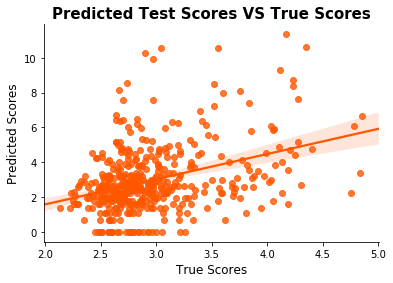

In [39]:
# Plot the predicted test scores against the true scores
pred = rcv.predict(X_test)
sns.regplot(pred,y_test, color = '#FF5700')
plt.title('Predicted Test Scores VS True Scores', fontsize = 15, weight = 'bold')
plt.ylabel('Predicted Scores', fontsize = 12)
plt.xlabel('True Scores', fontsize = 12)
sns.despine(); 

If the model worked perfectly, all points would fall on in a straight line with the equation y = x. However, the upward trend and approximately correct line fit in this plot indicates that the model isn't broken.

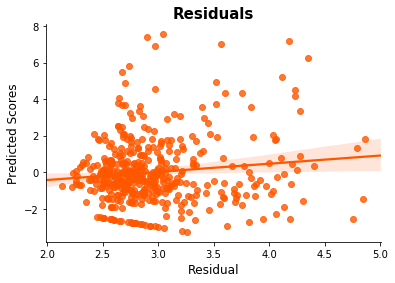

In [40]:
# Plot the residuals
sns.regplot(pred,y_test-pred, color = '#FF5700')
plt.title('Residuals', fontsize = 15, weight = 'bold')
plt.ylabel('Predicted Scores', fontsize = 12)
plt.xlabel('Residual', fontsize = 12)
sns.despine();

Here we can see that the residuals, while not completely random, don't seem to follow a trend.

# 10. Final Analysis

### Upvote Distributions of Commonly Used Words

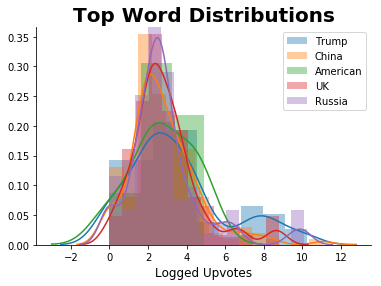

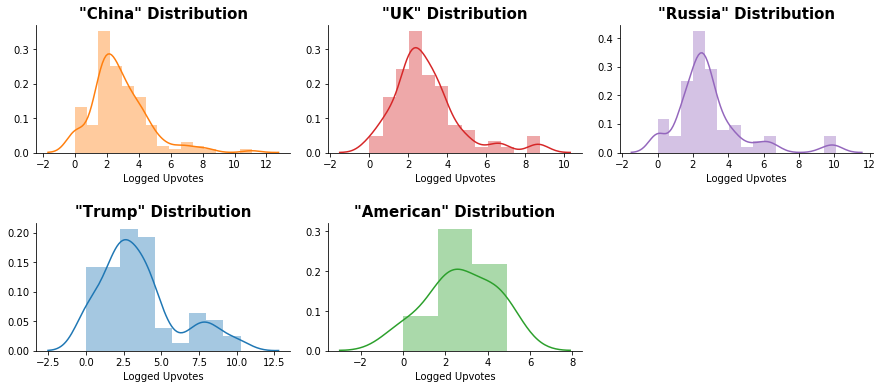

In [41]:
# Overlayed plots for direct, to scale, comparison
palette = sns.color_palette()

sns.distplot(regress[regress.trump > 0]['upvotes_logged'], label = 'Trump')
sns.distplot(regress[regress.china > 0]['upvotes_logged'], label = 'China')
sns.distplot(regress[regress.american > 0]['upvotes_logged'], label = 'American')
sns.distplot(regress[regress.uk > 0]['upvotes_logged'], label = 'UK')
sns.distplot(regress[regress.russia > 0]['upvotes_logged'], label = 'Russia')
plt.title('Top Word Distributions', fontsize = 20, weight = 'bold')
plt.xlabel('Logged Upvotes', fontsize = 12)
plt.legend()
sns.despine()
plt.show();

# Individual plots for clarity
plt.figure(figsize=[15,6])
plt.subplots_adjust(wspace=0.15, hspace=0.55) # Adjust size

plt.subplot(2,3,1)
sns.distplot(regress[regress.china > 0]['upvotes_logged'], label = 'China', color = palette[1])
plt.title('"China" Distribution', fontsize = 15, weight = 'bold')
plt.xlabel('Logged Upvotes', fontsize = 10)
sns.despine();

plt.subplot(2,3,2)
sns.distplot(regress[regress.uk > 0]['upvotes_logged'], label = 'UK', color = palette[3])
plt.title('"UK" Distribution', fontsize = 15, weight = 'bold')
plt.xlabel('Logged Upvotes', fontsize = 10)
sns.despine();

plt.subplot(2,3,3)
sns.distplot(regress[regress.russia > 0]['upvotes_logged'], label = 'Russia', color = palette[4])
plt.title('"Russia" Distribution', fontsize = 15, weight = 'bold')
plt.xlabel('Logged Upvotes', fontsize = 10)
sns.despine();

plt.subplot(2,3,4)
sns.distplot(regress[regress.trump > 0]['upvotes_logged'], label = 'Trump', color = palette[0])
plt.title('"Trump" Distribution', fontsize = 15, weight = 'bold')
plt.xlabel('Logged Upvotes', fontsize = 10)
sns.despine();

plt.subplot(2,3,5)
sns.distplot(regress[regress.american > 0]['upvotes_logged'], label = 'American', color = palette[2])
plt.title('"American" Distribution', fontsize = 15, weight = 'bold')
plt.xlabel('Logged Upvotes', fontsize = 10)
sns.despine();

From the distributions of upvotes for posts about common topics in the world news subreddit, it's clear that Reddit users react differently to topics about America than topics about other countries that are frequently in the news. The distribution for Trump appears to be bimodal, where there is another peak around 8 logged upvotes, showing that a disproportionate number of posts about Trump in particular seem to spark interest.

### Coefficient Interpretation

In [42]:
# View the feature coefficients in ascending order
coefs = []
for item1, item2 in zip(regress.columns.values,rcv.coef_):
    tup = (item1, item2)
    coefs.append(tup)

sorted(coefs, key=lambda x: x[1])

[('missing', -0.23565982598871094),
 ('military', -0.22226126342546676),
 ('khashoggi', -0.2142663523400846),
 ('jamal', -0.21115560226158098),
 ('visit', -0.20933937396905763),
 ('trade deal', -0.18843357341602487),
 ('iran', -0.18605576182338354),
 ('government', -0.18363788060194025),
 ('north', -0.17420257332837383),
 ('saudi', -0.17301305361055633),
 ('health', -0.16534662295049107),
 ('prison', -0.1624382408427186),
 ('officers', -0.16152026668420014),
 ('australian', -0.16149556038001137),
 ('dies', -0.15506244592973847),
 ('climate change', -0.15080628643413038),
 ('india', -0.14176418657475529),
 ('change', -0.13821896472416437),
 ('prime minister', -0.1374302729869395),
 ('sydney opera', -0.13622831753196424),
 ('public', -0.1346296525376027),
 ('ambassador', -0.1279499758747832),
 ('british', -0.12715319863508248),
 ('prize', -0.12651118905184552),
 ('years', -0.12401447090042236),
 ('west', -0.12388477232419803),
 ('worlds', -0.12201008557197618),
 ('reportedly', -0.1216596

We can see that certain words like "american" or "russia" contribute the most positively to upvotes, while "missing" and "military" contribute negatively. This means that, if you post on the world news subreddit about America or Russia, it's more likely to be seen than other topics. This confirms the existence of bias on Reddit.